In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import sys
sys.path.insert(1, "../python/functions")
sys.path.insert(2, "../python/architecture")

In [3]:
from data_prep_functions import mnist_prep
from model_functions import *
from plotting_functions import *
import no_gpu
import reproducible

In [4]:
X_train, X_test, y_train, y_test = mnist_prep()

# EnKF

In [5]:
batch_size = 600     # len(X_train)
epochs = 20
particles = 500
early_stopping = False
early_stopping_diff = 0.001
batch_normal = False # evtl. noch einbauen, obwohl im Paper nicht gemacht (aber Achtung mit den Dimensionen unten!!!)
shuffle = True
randomization = False

In [6]:
layers = 5
neurons = [128, 128, 64, 32, 10]
n_cols = X_train.shape[1]

In [7]:
delta = 0.005
h_0 = 2
epsilon = 0.5

In [8]:
n = len(X_train)
num_batches = int(np.ceil(n / batch_size))
batch_indices = np.cumsum([0] + list(np.ones(num_batches) * batch_size))
batch_indices[-1] = n

In [9]:
model_dict = {}
weights_dict = {}
y_pred_dict = {}
jacobian_dict = {}
weights_vector_dict = {}
train_acc_dict = {}
test_acc_dict = {}
iteration_dict = {}

# init_model already has weights and biases following the Glorot distribution
# it can already be used to predict and evaluate, but it is very bad (<10% accuracy)
# only used to determine shapes and shape_elements via its weights
init_model = nn_model_structure(layers = layers,
                                neurons = neurons,
                                n_cols = n_cols)
init_model = nn_model_compile(init_model,
                              optimizer = "sgd")
weights = init_model.get_weights()
# shape contains the shapes of the weight matrices and bias vectors as a list of arrays
shapes = [np.array(params.shape) for params in weights]
# shape_elements contains the indices of the weights as a vector and tells where to cut
shape_elements = np.cumsum([0] + [np.prod(shape) for shape in shapes])

In [10]:
for i in range(particles):
    # just an initial model with the correct structure regarding neurons, layers, activation functions, Glorot initialization
    model = nn_model_structure(layers = layers,
                               neurons = neurons,
                               n_cols = n_cols)
    model = nn_model_compile(model,
                             optimizer = "sgd")
    # for every particle write the model in a dictionary
    model_dict["model_{}".format(str(i+1))] = model
    
    # for every particles write the weights and biases in a dictionary
    weights_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                    .get_weights()
    
    train_acc_dict["model_{}".format(str(i+1))] = []
    test_acc_dict["model_{}".format(str(i+1))] = []
    iteration_dict["model_{}".format(str(i+1))] = []

In [11]:
# mean_model as the model with the mean of the weights of all particle models
mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
mean_model = init_model
mean_model.set_weights(mean_weights)

mean_model_train_acc = np.array(mean_model.evaluate(X_train, y_train)[1])
mean_model_test_acc = np.array(mean_model.evaluate(X_test, y_test)[1])

313/313 [==============================] - 0s 598us/step - loss: 2.3030 - accuracy: 0.0892


In [12]:
import time
start_time = time.time()

In [13]:
# loop over all epochs
for epoch in range(epochs):
    # shuffle the data
    if shuffle:
        indices = y_train.sample(frac=1).index
        X_batches = [X_train[indices][int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]
        y_batches = [y_train.iloc[indices].reset_index(drop = True)[int(batch_indices[i]):int(batch_indices[i+1])] for i in range(len(batch_indices)-1)]   
    # loop over all batches
    for b in range(num_batches):    
        for i in range(particles):
            # set new weights for model
            model_dict["model_{}".format(str(i+1))].set_weights(weights_dict["model_{}".format(str(i+1))])
            
            # for every particle write the predictions on the training batches in a dictionary
            y_pred_dict["model_{}".format(str(i+1))] = model_dict["model_{}".format(str(i+1))]\
                                                            .predict(X_batches[b])

            # for every particle write the Jacobian in a dictionary
            jacobian_dict["model_{}".format(str(i+1))] = (-1) * np.multiply(np.array(y_batches[b]), 
                                                                            np.array(1 / (y_pred_dict["model_{}".format(str(i+1))] + delta)))
            
        # compute the mean of the predictions
        y_pred_mean = np.mean(list(y_pred_dict.values()), axis = 0)
        
        # compute the matrix D elementwise
        d = np.zeros(shape = (particles, particles))
        for k in range(particles):
            y_pred_centered = y_pred_dict["model_{}".format(str(k+1))] - y_pred_mean
            for j in range(particles):
                d[k][j] = np.sum(np.multiply(y_pred_centered, jacobian_dict["model_{}".format(str(j+1))]))
        d = np.transpose(d)  
        
        # compute the scalar h_t
        h_t = h_0 / (np.sqrt(np.sum(d**2)) + epsilon)
        
        # Reshape the weights and biases so that they are no longer matrices and vectores, but now one single vector
        for i in range(particles):
            weights_array = np.array([])
            for j in range(len(weights_dict["model_{}".format(str(i+1))])):
                weights_array = np.append(weights_array, np.reshape(weights_dict["model_{}".format(str(i+1))][j], (1, -1)).ravel())
            weights_vector_dict["model_{}".format(str(i+1))] = weights_array
          
        # matrix with particle parameters as row vectors
        weights_all_ptcls = np.array(list(weights_vector_dict.values()))

        # compute the matrix with the updates for each particle
        weights_all_ptcls = weights_all_ptcls - h_t * np.matmul(d, weights_all_ptcls)

        for i in range(particles):
            # write the updates back into the dictionary
            weights_vector_dict["model_{}".format(str(i+1))] = weights_all_ptcls[i]
            # reshape the updates, so that they are of the original matrx and vector shape
            for l in range(len(shape_elements)-1):
                start = shape_elements[l]
                end = shape_elements[l+1]
                weights_dict["model_{}".format(str(i+1))][l] = np.reshape(weights_vector_dict["model_{}".format(str(i+1))][start:end], tuple(shapes[l]))
            if randomization:
                # add randomization/ noise to each particle
                new_weights = []
                # standard deviation for scaled Glorot distribution
                for s in range(len(shapes)):
                    if shapes[s].shape[0] == 2:
                        fan_in = shapes[s][0]
                        fan_out = shapes[s][1]
                    if shapes[s].shape[0] == 1:
                        fan_in = shapes[s-1][0]
                        fan_out = shapes[s][0]
                    stddev = np.sqrt(np.sqrt(h_t)) * np.sqrt(2 / (fan_in + fan_out))
                    noise = np.random.normal(loc = 0.0,
                                             scale = stddev,
                                             size = tuple(shapes[s]))
                    new_weights.append(weights_dict["model_{}".format(str(i+1))][s] + noise)
                weights_dict["model_{}".format(str(i+1))] = new_weights
                
    if randomization:
        # randomize particles around their mean
        weights_mean = list(np.mean(list(weights_dict.values()), axis = 0))
        for i in range(particles):
            new_weights = []
            # standard deviation for Glorot distribution
            for s in range(len(shapes)):
                if shapes[s].shape[0] == 2:
                    fan_in = shapes[s][0]
                    fan_out = shapes[s][1]
                if shapes[s].shape[0] == 1:
                    fan_in = shapes[s-1][0]
                    fan_out = shapes[s][0]
                stddev = np.sqrt(2 / (fan_in + fan_out))
                noise = np.random.normal(loc = 0.0,
                                         scale = stddev,
                                         size = tuple(shapes[s]))
                new_weights.append(weights_mean[s] + noise)
            weights_dict["model_{}".format(str(i+1))] = new_weights
            
    for i in range(particles):
        # for every particle write the training accuracy of the current iteration in a dictionary
        train_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_train, y_train, verbose = 0)[1])

        # for every particle write the test accuracy of the current iteration in a dictionary
        test_acc_dict["model_{}".format(str(i+1))].append(model_dict["model_{}".format(str(i+1))]\
                                                                  .evaluate(X_test, y_test, verbose = 0)[1])

        # for every particle write the current iteration in a dictionary
        iteration_dict["model_{}".format(str(i+1))].append("Epoch: {}, Batch: {}.".format(epoch+1, b+1))
            
    # update the mean_model
    mean_weights = list(np.mean(list(weights_dict.values()), axis = 0))
    mean_model.set_weights(mean_weights)
    
    mean_model_train_acc = np.append(mean_model_train_acc, np.array(mean_model.evaluate(X_train, y_train, verbose = 0)[1]))
    mean_model_test_acc = np.append(mean_model_test_acc, np.array(mean_model.evaluate(X_test, y_test, verbose = 0)[1]))
    
    print("Training Accuracy after Epoch {}: {}".format(str(epoch+1), str(np.round(mean_model_train_acc[-1], 3))))
    
    # early stopping
    if early_stopping:
        if epoch == 0:
            test_acc_old = 0
        else:
            test_acc_new = mean_model_test_acc[epoch]
            if np.absolute(test_acc_new - test_acc_old) <= early_stopping_diff:
                print("STOP: Early Stopping after epoch {} because improvement in test accuracy is only {}."\
                                                                     .format(epoch+1, test_acc_new - test_acc_old))
                break
            test_acc_old = test_acc_new

Training Accuracy after Epoch 1: 0.609
Training Accuracy after Epoch 2: 0.669
Training Accuracy after Epoch 3: 0.699
Training Accuracy after Epoch 4: 0.713
Training Accuracy after Epoch 5: 0.721
Training Accuracy after Epoch 6: 0.726
Training Accuracy after Epoch 7: 0.73
Training Accuracy after Epoch 8: 0.734
Training Accuracy after Epoch 9: 0.736
Training Accuracy after Epoch 10: 0.738
Training Accuracy after Epoch 11: 0.74
Training Accuracy after Epoch 12: 0.742
Training Accuracy after Epoch 13: 0.743
Training Accuracy after Epoch 14: 0.745


KeyboardInterrupt: 

In [14]:
end_time = time.time()
print("Calculation time: {} minutes.".format((end_time - start_time) / 60))

Calculation time: 537.194789715608 minutes.


In [15]:
y_pred_dict["model_1"]

array([[4.6326420e-03, 2.1746665e-02, 3.7497707e-02, ..., 2.2197011e-01,
        4.8313607e-03, 2.3738642e-01],
       [7.9085362e-01, 2.0668496e-05, 5.8572190e-03, ..., 9.5498915e-05,
        4.2871400e-03, 2.1605675e-04],
       [4.7454392e-03, 9.4363314e-01, 1.1123812e-02, ..., 1.4751195e-02,
        3.1874780e-04, 9.3105668e-03],
       ...,
       [2.2763219e-07, 2.1849876e-07, 9.9901187e-01, ..., 1.5759021e-11,
        5.3995202e-04, 1.4070611e-10],
       [2.8586122e-03, 3.4831320e-03, 3.0420167e-02, ..., 6.8011628e-05,
        1.9936012e-01, 7.3260039e-02],
       [5.6116737e-04, 1.8402982e-01, 3.7197149e-03, ..., 2.6643618e-03,
        1.3076676e-02, 1.5071493e-01]], dtype=float32)

In [16]:
jacobian_dict["model_1"]

array([[-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-1.2565125 , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -1.0541483 , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       ...,
       [-0.        , -0.        , -0.99600416, ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        , -0.        ]], dtype=float32)

In [17]:
print(np.round(mean_model_train_acc, 3))
print(np.round(mean_model_test_acc, 3))

[0.09  0.609 0.669 0.699 0.713 0.721 0.726 0.73  0.734 0.736 0.738 0.74
 0.742 0.743 0.745]
[0.089 0.604 0.663 0.698 0.712 0.722 0.73  0.734 0.737 0.741 0.744 0.746
 0.747 0.748 0.751]


In [18]:
train_acc_dict

{'model_1': [0.5925499796867371,
  0.6678833365440369,
  0.6991833448410034,
  0.7130666375160217,
  0.7211666703224182,
  0.7261833548545837,
  0.7304166555404663,
  0.7331166863441467,
  0.7361166477203369,
  0.7382833361625671,
  0.7402333617210388,
  0.7422000169754028,
  0.7432833313941956,
  0.7448333501815796],
 'model_2': [0.5918333530426025,
  0.6668333411216736,
  0.69923335313797,
  0.713100016117096,
  0.7214333415031433,
  0.7261333465576172,
  0.7302500009536743,
  0.7334666848182678,
  0.7360166907310486,
  0.7380666732788086,
  0.7399166822433472,
  0.7420499920845032,
  0.7434333562850952,
  0.7446333169937134],
 'model_3': [0.5850333571434021,
  0.6639500260353088,
  0.698033332824707,
  0.7125166654586792,
  0.7207666635513306,
  0.7260000109672546,
  0.7301833629608154,
  0.7329999804496765,
  0.735450029373169,
  0.7378000020980835,
  0.7397500276565552,
  0.7415666580200195,
  0.743066668510437,
  0.7442499995231628],
 'model_4': [0.5814499855041504,
  0.666183352

In [19]:
test_acc_dict

{'model_1': [0.5931000113487244,
  0.6635000109672546,
  0.6970000267028809,
  0.7116000056266785,
  0.7213000059127808,
  0.7293000221252441,
  0.7342000007629395,
  0.7390000224113464,
  0.7419000267982483,
  0.7434999942779541,
  0.7462000250816345,
  0.7483999729156494,
  0.7488999962806702,
  0.7505999803543091],
 'model_2': [0.5878000259399414,
  0.6603999733924866,
  0.6970000267028809,
  0.7117000222206116,
  0.7232000231742859,
  0.7294999957084656,
  0.7333999872207642,
  0.7372999787330627,
  0.7412999868392944,
  0.7437000274658203,
  0.7455999851226807,
  0.7472000122070312,
  0.7480999827384949,
  0.7504000067710876],
 'model_3': [0.5827999711036682,
  0.6615999937057495,
  0.6980999708175659,
  0.7127000093460083,
  0.7217000126838684,
  0.728600025177002,
  0.7337999939918518,
  0.7372999787330627,
  0.7408999800682068,
  0.7429999709129333,
  0.745199978351593,
  0.7476000189781189,
  0.7483999729156494,
  0.7502999901771545],
 'model_4': [0.5809000134468079,
  0.65960

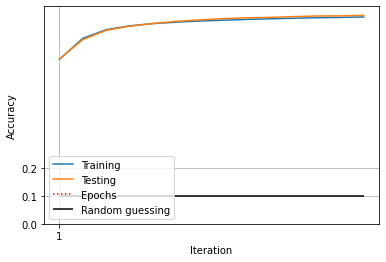

In [20]:
nn_plot_iter_acc(train_acc_dict["model_1"],
                 test_acc_dict["model_1"],
                 iteration_dict["model_1"],
                 mean_comparison = 0.1)

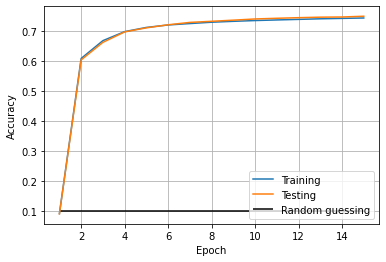

In [21]:
nn_plot_epoch_acc(mean_model_train_acc,
                  mean_model_test_acc,
                  mean_comparison = 0.1,
                  savefig = True,
                  file = "../img/enkf_model_mnist_full_E{}_B{}_P{}_H{}.png".format(epochs, batch_size, particles, h_0))

In [22]:
nn_save(mean_model, 
        "../models/enkf_model_mnist_full_E{}_B{}_P{}_H{}.h5".format(epochs, batch_size, particles, h_0))